**No, PyTorch parallelism does NOT run on Apache Spark.**

**Why they're different:**
• **PyTorch Distributed** = GPU-to-GPU training engine (NVIDIA Collective Communication Library, fast gradient sync)
• **Apache Spark** = Big data processing engine (Extract Transform Load, preprocessing)

**Real workflow:**
• **Stage 1:** Spark processes petabytes of raw data → clean training datasets
• **Stage 2:** PyTorch Distributed trains models on GPU clusters

**They work together, not as one system.**

**Note:** Spark would be too slow for neural network training due to lack of low-latency GPU communication needed for backpropagation.

---
---

No, we **cannot** divide the whole Big Data ecosystem into just two types: tools using **Spark engine** and tools using **MapReduce engine**. That’s **oversimplified** and **not accurate**.

Instead, Big Data tools span **multiple layers** with **varied roles**:

### 1. **Storage Layer**

* **HDFS** (used by both MapReduce and Spark)
* **HBase**, **Hive tables**, **NoSQL DBs**

### 2. **Processing Engines**

* **MapReduce** → older batch processing
* **Spark** → fast, in-memory, batch + stream
* **Flink**, **Storm**, **Tez**, **Samza** → other engines

### 3. **Query Engines**

* **Hive** (can run on MapReduce, Tez, or Spark)
* **Presto**, **Impala** → not Spark or MapReduce
* **Drill**

### 4. **Workflow Schedulers**

* **Oozie**, **Airflow**, **Azkaban**

### 5. **Ingestion Tools**

* **Sqoop**, **Flume**, **Kafka**, **NiFi**

### 6. **Cluster Managers**

* **YARN**, **Mesos**, **Kubernetes**

### Summary:

Some tools **can use both engines** (e.g., Hive can run with MapReduce, Tez, or Spark). So, the correct view is:

> **There are multiple engines** (Spark, MapReduce, Tez, Flink, etc.), and **many tools** that either sit on top of them or work independently.

You **cannot** cleanly divide all tools into "Spark-based" and "MapReduce-based" buckets.


---
---


## Complete Technology Matrix by Use Case

| **Use Case** | **Primary Technologies** |
|--------------|-------------------------|
| **Real-time Analytics** | Kafka + Flink + Druid/ClickHouse |
| **Data Lake Architecture** | S3/HDFS + Spark + Airflow + Glue/Atlas |
| **ML Pipeline** | Spark + TensorFlow/PyTorch + MLflow + SageMaker |
| **BI Dashboard** | BigQuery/Snowflake + dbt + Tableau/Power BI |
| **Event-driven Architecture** | Kafka + Flink + Cassandra/DynamoDB |
| **Traditional Data Warehouse** | Sqoop + Hive + Airflow + Tableau |

---
---

# Big Data Ecosystem - Complete Guide

## Section 1: Foundation Concepts

### What is Big Data
- **Volume, Velocity, Variety** - the 3 V's
- **Distributed computing basics** - spreading work across multiple machines
- **CAP theorem** - Consistency, Availability, Partition tolerance (pick 2)
- **Horizontal vs Vertical scaling** - adding more machines vs bigger machines
- **Master-slave architecture patterns** - coordinator nodes + worker nodes

### Core Insight: Web vs Big Data Similarities
Both domains solve the same fundamental challenges:
- **Real-Time Messaging**: WebSockets ↔ Kafka (bidirectional communication)
- **Performance**: CDN ↔ Redis/Caching (distribute closer to consumers)  
- **Architecture**: Microservices ↔ Data Mesh (independent, manageable services)
- **Communication**: REST APIs ↔ Data APIs (request-response patterns)
- **Events**: Pub/Sub ↔ Kafka Topics (broadcast to subscribers)

---
---

## section 2: Key Technology Evolution Summary

**Storage Evolution**: Local disks → HDFS → Cloud object storage (S3, etc.)

**Processing Evolution**: MapReduce (disk) → Spark engine (memory) → Specialized engines → Cloud services

**Architecture Evolution**: Monolithic → Hadoop ecosystem → Cloud-native → Lakehouse architecture

### Modern Architecture Patterns

**Traditional Data Warehouse**:
```
Data Sources → Sqoop → HDFS → Hive → Airflow → Tableau
```

**Modern Lakehouse (Databricks)**:
```
Data Sources → Databricks Lakehouse → All Analytics & AI
```

**Real-time Analytics**:
```
Kafka + Flink + Druid/ClickHouse
```

**ML Pipeline**:
```
Spark engine + TensorFlow/PyTorch + MLflow + SageMaker
```

---

## Sqoop Deep Dive

### What Sqoop Actually Uses
- **JDBC drivers** to connect to databases (MySQL, PostgreSQL, Oracle)
- **MapReduce jobs** to parallelize data transfer
- **Code generation** - creates Java POJOs (not full ORM)

### Why POJOs, Not ORM?
Sqoop moves millions/billions of rows efficiently. ORM overhead would hurt performance.

| Aspect | ORM Approach | Sqoop's POJO Approach |
|--------|--------------|----------------------|
| **Speed** | Slower - ORM overhead | Faster - Direct mapping |
| **Memory** | Higher - metadata/proxies | Lower - just data fields |
| **Parallelization** | Complex - session conflicts | Simple - stateless POJOs |
| **Scalability** | Limited - app-level | Unlimited - scales with cluster |

### Sqoop Import Example
```bash
sqoop import \
  --connect jdbc:mysql://localhost:3306/retail_db \
  --username root --password cloudera \
  --m 2 --split-by customer_id \
  --table customers \
  --target-dir /user/cloudera/data_import
```

**Key Points**:
- Default mappers = 4 if not specified
- Must specify --split-by when mappers > 1
- Uses primary key as split-by if available
- Map-only jobs (no reducers needed for direct copy)

### Why Map-Only Jobs for Sqoop?
1. **No aggregation needed** - direct copy from source to target
2. **Parallel direct writes** - each mapper writes to HDFS
3. **Maximum performance** - no shuffle/sort overhead
4. **Data partitioning** - splits by primary key ranges

---
---

## Section 3: Processing Engines

### Hadoop Evolution Context
**Hadoop 1.x (2011-2012)**:
- Core: HDFS + MapReduce only
- MapReduce handles both processing AND resource management
- Limitation: Single point of failure, batch processing only

**Hadoop 2.x (2013-2017)**:
- Major Addition: YARN introduced
- Key Change: Separated resource management from processing
- Benefits: Multi-tenancy, better resource utilization, NameNode HA

**Hadoop 3.x (2017-present)**:
- Storage: Erasure coding reduces overhead from 200% to 50%
- Performance: Better resource utilization, GPU scheduling
- Features: Multiple NameNodes, enhanced security, Java 8+

### 1. MapReduce Engine
**What it is**: Original distributed processing engine (2004)

**How it works**:
- **Map phase** → process data in parallel across nodes
- **Reduce phase** → aggregate results from map tasks

**Key characteristics**:
- Disk-based processing (slow but reliable)
- Fault tolerant through task re-execution
- Simple programming model
- Batch processing only
- Status: Largely replaced by Spark engine

**MapReduce Example Workflow**:
```python
# Mapper reads CSV, computes revenue per country
Country → Revenue (parallel processing)

# Hadoop framework shuffles and sorts by country
# Reducer aggregates total revenue per country
Country → Total_Revenue
```

### 2. Spark Engine  
**What it is**: Distributed processing engine with in-memory capabilities

**Key advantages over MapReduce**:
- **In-memory processing** vs disk-based
- **Faster execution** - keeps data in memory between operations
- **Unified engine** that supports multiple interfaces and APIs

**Technologies that run on Spark engine**:
- **Spark SQL** - SQL interface for structured data
- **Spark Streaming** - real-time stream processing interface
- **MLlib** - machine learning library
- **GraphX** - graph processing library

### 3. Other Processing Engines
**Apache Flink**:
- Stream-first processing engine
- Low-latency stream processing
- Event time processing

**Apache Storm**:
- Real-time stream processing engine
- Tuple-based processing model
- Low-latency guarantees

**Presto/Trino**:
- Distributed SQL query engine
- Interactive analytics
- Cross-data source queries

**Apache Beam**:
- Unified programming model
- Batch and stream processing
- Portable across engines

### Hive vs Spark SQL Comparison
| Feature | Hive (on MapReduce) | Spark SQL |
|---------|-------------------|-----------|
| **Engine** | Uses MapReduce | Uses Spark engine (in-memory) |
| **Speed** | Slower (reads/writes to disk) | Faster (in-memory processing) |
| **Latency** | High (batch only) | Low (supports real-time) |
| **Use Case** | Good for batch processing | Good for batch + streaming |

**Bottom line**: Use Hive for slow batch jobs, Spark SQL for fast flexible SQL processing.

**Note**: Spark is the **engine**, Spark SQL is the **SQL interface** on top of the Spark engine.

---
---




## Section 4: Distributed Storage

### HDFS (Hadoop Distributed File System)
**What it is**: Distributed file system (not a database) - foundational component

**Key Characteristics**:
- **Distributed storage** across commodity hardware
- **Fault tolerant** with automatic replication (typically 3x)
- **Large file optimization** for big files & sequential reads
- **Write-once, read-many** access pattern
- **Block-based** with default 128MB block size

#### 1. MapReduce Engine Technologies on HDFS:
- **Apache Hive** → SQL-like queries over HDFS using MapReduce
- **Apache HBase** → NoSQL database on HDFS with MapReduce integration
- **Traditional Hadoop jobs** → Direct MapReduce programming

#### 2. Spark Engine Technologies on HDFS:
- **Spark SQL** → Fast SQL queries on HDFS data
- **Spark Core** → Direct Spark applications reading/writing HDFS
- **MLlib** → Machine learning on HDFS datasets
- **Spark Streaming** → Stream processing with HDFS checkpointing

#### 3. Other Engine Technologies on HDFS:
- **Apache Impala** → Real-time SQL with own MPP engine
- **Presto/Trino** → Distributed SQL query engine
- **Apache Drill** → Schema-free SQL query engine

### Cloud Storage Solutions
| **Provider** | **Storage Service** |
|--------------|-------------------|
| **AWS** | S3, Redshift, DynamoDB |
| **Azure** | Data Lake, Synapse, Cosmos DB |
| **Google Cloud** | Cloud Storage, BigQuery |
| **Commercial** | Snowflake, MongoDB |

### Other Distributed Storage Systems
- **Apache Cassandra** (NoSQL distributed)
- **Amazon S3** (object storage service)
- **Apache Ceph** (unified storage system)
- **MinIO** (S3-compatible object storage)

### Big Data Sequence File Formats

**Columnar Storage Formats** (60-80% compression):
- **Apache Parquet** - Open source columnar format, excellent for analytics
- **Apache ORC** (Optimized Row Columnar) - Hadoop-optimized columnar format
- **Apache Arrow** - In-memory columnar format for fast processing

**Row-based Storage Formats** (40-60% compression):
- **Apache Avro** - Row-based with schema evolution support
- **Hadoop Sequence Files** - Key-value pairs, Hadoop-native binary format
- **Apache Thrift** - Cross-language serialization framework
- **Protocol Buffers (protobuf)** - Google's binary serialization format

**Hybrid/Table Formats** (60-75% compression):
- **Delta Lake** - ACID transactions on data lakes
- **Apache Iceberg** - Table format with schema evolution and time travel
- **Apache Hudi** - Incremental data processing on data lakes

**Compressed Binary Formats**:
- **MessagePack** - Efficient binary serialization
- **Apache Arrow Flight** - High-performance data transport
- **FlatBuffers** - Zero-copy serialization library

---
---



## Section 5: Resource Managers

### YARN (Yet Another Resource Negotiator)
**What it does**: Manages cluster resources and job scheduling

**Key functions**:
- Allocates containers on cluster nodes for map/reduce tasks
- Tracks task status and handles failures
- Enables multiple applications to run simultaneously
- Provides better resource utilization than Hadoop 1.x

#### 1. MapReduce Engine on YARN:
- **Traditional Hadoop MapReduce** → Native YARN application
- **Apache Hive on MapReduce** → Uses YARN for resource allocation
- **Apache Pig** → MapReduce-based data flow language on YARN

#### 2. Spark Engine on YARN:
- **Spark applications** → Run as YARN applications
- **Spark SQL** → Managed by YARN resource scheduler
- **Spark Streaming** → Long-running YARN applications
- **MLlib jobs** → Distributed ML training on YARN cluster

#### 3. Other Engines on YARN:
- **Apache Flink** → Can run on YARN cluster
- **Apache Storm** → YARN integration available
- **Apache Tez** → Optimized execution engine on YARN

### Other Resource Management Systems

#### Apache Mesos
- **What it is**: Datacenter operating system for resource abstraction
- **Engines supported**: Spark, Marathon, Chronos, Hadoop

#### Kubernetes  
- **What it is**: Container orchestration platform
- **Engines supported**: Spark (Spark on K8s), Flink, custom containerized applications

#### Standalone Cluster Managers
- **Spark Standalone** → Built-in cluster manager for Spark engine only
- **Flink Standalone** → Native cluster manager for Flink applications

### Cloud Resource Managers
| **Provider** | **Service** | **Engines Supported** |
|--------------|-------------|----------------------|
| **AWS** | EMR, ECS, EKS | Spark, Hadoop, Flink, Presto |
| **Azure** | HDInsight, AKS | Spark, Hadoop, Kafka, HBase |
| **Google Cloud** | Dataproc, GKE | Spark, Hadoop, Flink, Beam |

---
---


## Section 6: Types of Processing (Categorized by Engine)

### 1. Batch Processing
**What**: Process large volumes of data at rest
**When**: Scheduled jobs, ETL, historical analysis
**Example**: Daily sales reports, data warehouse loading

#### MapReduce Engine Technologies:
- **Hadoop MapReduce** → Traditional batch processing
- **Apache Hive** → SQL on MapReduce for batch analytics
- **Apache Pig** → Data flow scripting on MapReduce

#### Spark Engine Technologies:
- **Spark Core** → Fast in-memory batch processing
- **Spark SQL** → SQL-based batch analytics
- **MLlib** → Batch machine learning training

#### Other Engine Technologies:
- **Apache Tez** → Optimized batch execution engine
- **AWS EMR** → Managed batch processing service
- **Google Dataflow** → Serverless batch processing

### 2. Stream Processing  
**What**: Process continuous data streams in real-time
**When**: Real-time analytics, monitoring, alerts
**Example**: Fraud detection, live dashboards

#### MapReduce Engine Technologies:
- **None** → MapReduce not suitable for stream processing

#### Spark Engine Technologies:
- **Spark Streaming** → Micro-batch stream processing on Spark
- **Structured Streaming** → Unified batch/stream API

#### Other Engine Technologies:
- **Apache Flink** → Native stream processing engine
- **Apache Storm** → Real-time stream processing
- **Kafka Streams** → Stream processing library
- **AWS Kinesis Analytics** → Managed stream processing
- **Azure Stream Analytics** → Cloud stream processing
- **Google Dataflow** → Unified batch/stream processing

### 3. SQL Processing
**What**: Distributed SQL queries across large datasets  
**When**: Interactive analytics, business intelligence
**Example**: Ad-hoc queries, reporting

#### MapReduce Engine Technologies:
- **Apache Hive** → SQL on MapReduce (HiveQL)
- **Apache Drill** → Schema-free SQL on various engines

#### Spark Engine Technologies:
- **Spark SQL** → SQL interface on Spark engine
- **DataFrame API** → Programmatic SQL on Spark

#### Other Engine Technologies:
- **Presto/Trino** → Distributed SQL query engine
- **Apache Impala** → Real-time SQL with MPP architecture
- **AWS Redshift** → Cloud data warehouse
- **Azure Synapse** → Analytics service
- **Google BigQuery** → Serverless data warehouse
- **Snowflake** → Cloud data platform

### 4. Machine Learning Processing
**What**: Distributed training and inference
**When**: Large-scale ML model training
**Example**: Training recommendation systems

#### MapReduce Engine Technologies:
- **Apache Mahout** → ML algorithms on MapReduce (mostly deprecated)

#### Spark Engine Technologies:
- **MLlib** → Spark's machine learning library
- **Spark ML Pipelines** → ML workflow management

#### Other Engine Technologies:
- **TensorFlow Distributed** → Google's ML framework
- **PyTorch Distributed** → Facebook's ML framework
- **Apache MXNet** → Flexible deep learning framework
- **AWS SageMaker** → Managed ML platform
- **Azure Machine Learning** → Cloud ML service
- **Google AI Platform** → Managed ML service

### 5. Graph Processing
**What**: Analyze relationships and connections
**When**: Social networks, recommendation engines
**Example**: Friend recommendations, fraud networks

#### MapReduce Engine Technologies:
- **Apache Giraph** → Graph processing on Hadoop

#### Spark Engine Technologies:
- **GraphX** → Graph processing library on Spark

#### Other Engine Technologies:
- **Apache TinkerPop** → Graph computing framework
- **Neo4j** → Native graph database
- **Amazon Neptune** → Managed graph database

### Data Movement & Integration Technologies
**Data Ingestion**:
- Open Source: Apache Kafka, NiFi, Sqoop
- AWS: Kinesis, DMS
- Azure: Event Hubs, Data Factory
- Google Cloud: Pub/Sub, Dataflow

### OLTP vs OLAP
**OLTP (Online Transaction Processing)**: Real-time high-volume transactions
- Tools: Cassandra, HBase, DynamoDB, MongoDB, CockroachDB

**OLAP (Online Analytical Processing)**: Complex analytical queries  
- Tools: Spark, Hive, Redshift, BigQuery, Druid, Snowflake

---


# Storage: 

## 1. hdfs - Storage layer, batch analytics, sequential reads.


---
---
---

# Database layer : 

1.  If you want **NoSQL → HBase**
2.  If you want **SQL → PostgreSQL/MySQL** (or at scale → Spanner, CockroachDB, Yugabyte).

## 1. hbase - Database layer, real-time queries, random reads/writes.

You can query HBase with SQL-like layers on top:

- Apache Phoenix → Adds SQL support on HBase (JDBC compatible).
- Hive on HBase → Integrates Hive queries with HBase tables.

## 2.sql normal for big data also , but some are there as non famous like spanner


# query engines:

## 1. hive: 
- hive can use spark or mapreduce as engine , but it is just a methodology having purpose of datawarehouse management & batch processing.

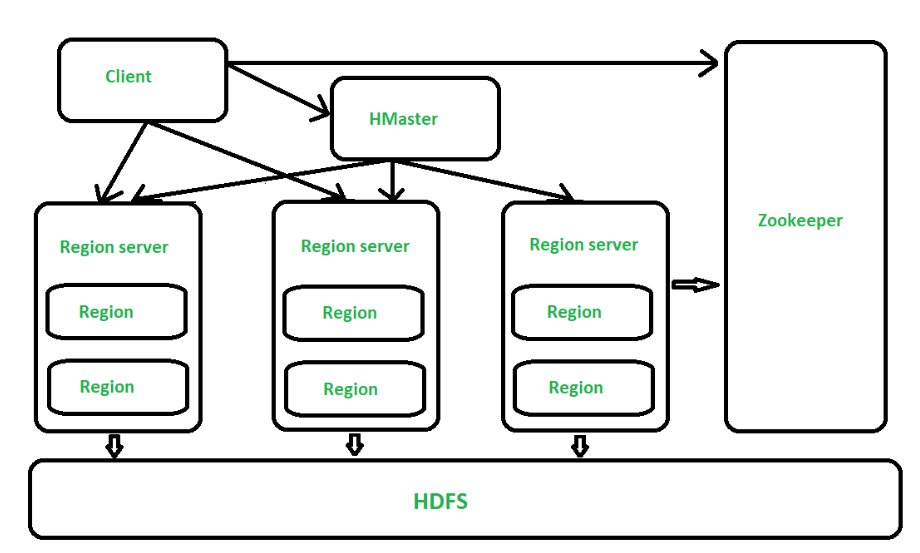


- real comparision is hive vs spark-sql
- Use Hive with map-reduce engine for slow batch jobs, Spark-sql for fast flexible processing.
- hive on spark engine is called hive-on-spark.
- SQL processing:
    - Open Source: Apache Hive, Spark SQL (on Spark engine), Presto/Trino
    - AWS: Redshift, Athena
    - Azure: Synapse Analytics
    - Google Cloud: BigQuery
    - Commercial: Snowflake
## Hive Complete Reference Notes

**1. Managed vs External Table Types**

• Managed Tables (Internal Tables)
  - `CREATE TABLE employees (id INT, name STRING, salary DOUBLE);`
  - Hive manages both metadata and data storage
  - Data stored in Hive warehouse directory (`/user/hive/warehouse` by default)
  - When table is dropped, both metadata and data are deleted permanently
  - Hive has full control over table lifecycle
    * Creates directories automatically
    * Manages file organization
    * Handles data cleanup on DROP TABLE
  - Best for tables entirely managed by Hive applications
  - Default table type when not specified

• External Tables
  - `CREATE EXTERNAL TABLE ext_employees (id INT, name STRING) LOCATION '/user/data/employees';`
  - Hive manages only metadata, not the actual data files
  - Data stored in user-specified location outside Hive warehouse
  - When table is dropped, only metadata is removed, data remains intact
  - Data can be shared across multiple applications and tools
    * Other systems can read/write the same data
    * Data persists beyond Hive table lifecycle
    * Useful for data lakes and shared storage scenarios
  - Required when data already exists in specific HDFS location
  - Safer option when data should not be accidentally deleted

• Key differences and selection criteria
  - **Data ownership**: Managed tables owned by Hive, external tables owned by user
  - **Drop behavior**: Managed tables delete data, external tables preserve data
  - **Location control**: Managed tables use warehouse, external tables use custom paths
  - **Use managed for**: Temporary tables, Hive-specific processing, ETL intermediates
  - **Use external for**: Shared data, existing datasets, data lake scenarios

**2. Hive Table Types and Operations**

• Staging tables concept
  - Temporary tables used for data preprocessing and validation
  - `CREATE TABLE staging_sales (date STRING, amount STRING, product STRING);`
  - Often use STRING data types initially for flexible data loading
  - Used to clean, validate, and transform data before loading to production tables
    * Handle data quality issues
    * Perform data type conversions
    * Apply business rules and validations
  - Typically dropped after successful data processing

• Dropping tables safely
  - `DROP TABLE table_name;`: Removes table completely
  - `DROP TABLE IF EXISTS table_name;`: Prevents errors if table doesn't exist
  - `TRUNCATE TABLE table_name;`: Removes all data but keeps table structure
    * Faster than DELETE for removing all records
    * Resets table to empty state
    * Cannot be used with external tables
  - `ALTER TABLE table_name DROP PARTITION (year=2023);`: Remove specific partitions

• Table creation variations
  - `CREATE TABLE LIKE existing_table;`: Copy structure without data
  - `CREATE TABLE AS SELECT (CTAS);`: Create table with data from query
  - `CREATE TEMPORARY TABLE temp_data (...);`: Session-specific tables
    * Automatically dropped when session ends
    * Not visible to other users or sessions
    * Useful for intermediate processing steps

**3. Data Loading: Local vs HDFS Operations**

• Loading from local filesystem
  - `LOAD DATA LOCAL INPATH '/home/user/data.txt' INTO TABLE employees;`
  - Copies data from local file system to HDFS
  - Original file remains in local filesystem
  - Data transferred over network to HDFS
    * Slower for large files due to network transfer
    * Useful for small datasets and development
    * File must exist on machine running Hive client
  - `OVERWRITE` option replaces existing data

• Moving from HDFS
  - `LOAD DATA INPATH '/user/data/employees.txt' INTO TABLE employees;`
  - Moves data files from HDFS location to table location
  - Original files are moved, not copied
    * Much faster operation (metadata update only)
    * No additional storage space required
    * Source files no longer exist in original location
  - Preferred method for large datasets already in HDFS
  - Files must be compatible with table schema and format

• Loading considerations and best practices
  - **Performance**: HDFS move operations much faster than local copy
  - **Data formats**: Ensure file format matches table definition
  - **Partitioning**: Use partition specification for partitioned tables
  - **File organization**: Multiple files loaded as separate data files
  - **Permissions**: Ensure proper HDFS permissions for data access
  - **Validation**: Test with small datasets before bulk loading

**4. Schema on Read Features**

• Core concept and benefits
  - Schema applied when data is read, not when data is written
  - Data stored in raw format without immediate schema validation
  - Flexible data ingestion without upfront schema definition
    * Accept data in various formats and structures
    * Handle schema evolution gracefully
    * Support for semi-structured and unstructured data
  - Contrast with traditional databases (schema on write)

• Implementation in Hive
  - `CREATE TABLE flexible_data (col1 STRING, col2 STRING, col3 STRING);`
  - Data type conversion happens during query execution
  - SerDe (Serializer/Deserializer) handles format interpretation
    * JSON SerDe for JSON data
    * Regex SerDe for custom text formats
    * Avro SerDe for Avro files
  - NULL values returned for incompatible data types

• Advantages and considerations
  - **Fast data ingestion**: No validation overhead during loading
  - **Schema flexibility**: Handle varying data structures
  - **Storage efficiency**: Store raw data without transformation
  - **Query-time overhead**: Type conversion during each query
  - **Data quality**: Potential issues discovered only during queries
  - **Best practices**: Validate critical data paths and common queries

**5. Creating Tables from Existing Tables**

• CREATE TABLE AS SELECT (CTAS)
  - `CREATE TABLE high_earners AS SELECT * FROM employees WHERE salary > 100000;`
  - Creates new table with data populated from query results
  - Schema automatically inferred from SELECT statement
  - Data copied during table creation process
    * New table independent of source table
    * Snapshot of data at creation time
    * Changes to source table don't affect new table
  - Cannot specify additional table properties or detailed schema

• CREATE TABLE LIKE
  - `CREATE TABLE employees_backup LIKE employees;`
  - Copies table structure without copying data
  - Preserves column names, data types, and table properties
  - Useful for creating backup tables or similar structures
    * Maintains partitioning scheme
    * Copies storage format and SerDe properties
    * Preserves bucketing configuration
  - Data loaded separately using INSERT or LOAD statements

• Advanced table creation patterns
  - `CREATE TABLE monthly_sales PARTITIONED BY (year INT, month INT) AS SELECT ...;`
  - Combine CTAS with partitioning for organized data storage
  - Use for creating materialized views and summary tables
  - Efficient way to restructure existing data with new organization

**6. Hive Partitions**

• Partition types and concepts
  - **Static partitioning**: Partition values specified explicitly
  - **Dynamic partitioning**: Partition values determined from data
  - Partitions create separate subdirectories for different partition values
  - Dramatically improves query performance by partition pruning
    * Queries scan only relevant partitions
    * Reduces I/O and processing time
    * Essential for time-series and categorical data organization

• Static partition insertion
  - `INSERT INTO TABLE sales PARTITION (year=2023, month=12) SELECT product, amount FROM staging_sales;`
  - Partition values explicitly specified in INSERT statement
  - All inserted records go to the same partition
  - Simple and predictable partition assignment
    * Full control over data placement
    * Suitable for batch processing known time periods
    * Prevents accidental data placement in wrong partitions

• Static partition loading
  - `LOAD DATA INPATH '/user/data/sales_2023_12.txt' INTO TABLE sales PARTITION (year=2023, month=12);`
  - Data files loaded directly to specific partition
  - Faster than INSERT for bulk data loading
  - File-based partition population
    * Maintains original file structure
    * No data transformation during loading
    * Efficient for pre-organized data files

• Dynamic partitioning configuration
  - `SET hive.exec.dynamic.partition=true;`: Enable dynamic partitioning
  - `SET hive.exec.dynamic.partition.mode=nonstrict;`: Allow all dynamic partitions
  - `SET hive.exec.max.dynamic.partitions=1000;`: Maximum partitions per node
  - `SET hive.exec.max.dynamic.partitions.pernode=100;`: Maximum partitions per mapper

• Dynamic partition insertion
  - `INSERT INTO TABLE sales PARTITION (year, month) SELECT product, amount, year, month FROM staging_sales;`
  - Partition values determined from data columns
  - Automatically creates partitions based on distinct values
  - Partition columns must be last in SELECT statement
    * Order matters for multi-level partitioning
    * Creates hierarchical directory structure
    * Handles multiple partitions in single operation

• Default and advanced partition handling
  - `__HIVE_DEFAULT_PARTITION__`: Default name for NULL partition values
  - `ALTER TABLE sales ADD PARTITION (year=2024, month=1);`: Manual partition creation
  - `ALTER TABLE sales DROP PARTITION (year=2022);`: Remove old partitions
  - Partition pruning optimization automatically applied in queries
  - Regular partition maintenance required for optimal performance

**7. Creating Tables from Sequence File Data**

• Sequence file table creation
  - `CREATE TABLE seq_employees (id INT, name STRING, salary DOUBLE) STORED AS SEQUENCEFILE;`
  - Optimized for MapReduce processing and compression
  - Binary format with better performance than text files
  - Splittable format enabling parallel processing
    * Each split processed by separate mapper
    * Maintains record boundaries across splits
    * Efficient for large dataset processing

• Loading sequence file data
  - `LOAD DATA INPATH '/user/data/employees.seq' INTO TABLE seq_employees;`
  - Files must be in proper SequenceFile format
  - Compatible with MapReduce input/output formats
  - Preserves compression and serialization benefits
    * Faster query processing
    * Reduced storage requirements
    * Better network utilization

• Sequence file benefits and use cases
  - **Performance**: Faster read/write operations than text files
  - **Compression**: Efficient compression support (block and record level)
  - **Splittability**: Enables parallel processing across cluster
  - **Integration**: Native MapReduce compatibility
  - **Use cases**: Large batch processing, ETL intermediates, compressed storage
  - **Considerations**: Not human-readable, requires compatible tools

**8. Hive Buckets (Clustering)**

• Bucketing concept and implementation
  - `CREATE TABLE bucketed_sales (id INT, product STRING, amount DOUBLE) CLUSTERED BY (id) INTO 4 BUCKETS;`
  - Distributes data into fixed number of files based on hash function
  - Hash function applied to bucketing column determines file placement
  - Each bucket stored as separate file within table/partition directory
    * Predictable file organization
    * Consistent data distribution
    * Enables sampling and join optimizations

• Bucketing configuration and loading
  - `SET hive.enforce.bucketing=true;`: Enable automatic bucketing
  - `INSERT INTO TABLE bucketed_sales SELECT * FROM raw_sales;`
  - Number of reducers should match number of buckets
  - Hash function ensures even data distribution across buckets
    * Prevents data skew in processing
    * Enables efficient sampling queries
    * Optimizes join operations between bucketed tables

• Bucketing benefits and optimization
  - **Sampling**: `SELECT * FROM bucketed_sales TABLESAMPLE(BUCKET 1 OUT OF 4);`
  - **Join optimization**: Bucket joins for co-located data
  - **Map-side joins**: Efficient joins when both tables bucketed on join key
  - **Consistent performance**: Predictable query execution times
    * Eliminates data skew issues
    * Enables parallel processing optimizations
    * Improves resource utilization

• Advanced bucketing features
  - `CLUSTERED BY (id) SORTED BY (timestamp) INTO 4 BUCKETS;`: Combine bucketing with sorting
  - Sorted buckets enable faster range queries and aggregations
  - Multiple column bucketing for complex data distribution
  - Integration with partitioning for hierarchical data organization

**9. Schema Evolution**

• Schema evolution capabilities
  - Add new columns to existing tables without data migration
  - `ALTER TABLE employees ADD COLUMNS (department STRING, hire_date DATE);`
  - New columns appear as NULL for existing records
  - Maintains backward compatibility with existing data
    * Old queries continue to work unchanged
    * New queries can access additional columns
    * No downtime required for schema changes

• Column modification operations
  - `ALTER TABLE employees CHANGE COLUMN name full_name STRING;`: Rename columns
  - `ALTER TABLE employees CHANGE COLUMN salary salary DECIMAL(10,2);`: Change data types
  - Compatible type changes preserve existing data
  - Incompatible changes may require data conversion
    * String to numeric conversions
    * Date format standardization
    * Precision and scale adjustments

• Schema evolution best practices
  - **Additive changes**: Safest approach - only add new columns
  - **Default values**: Consider default values for new columns
  - **Data validation**: Test schema changes with sample queries
  - **Rollback planning**: Maintain ability to revert schema changes
  - **Documentation**: Track schema evolution for data governance
  - **Version control**: Maintain schema history and change logs

• Handling schema conflicts
  - SerDe-specific schema evolution capabilities
  - Avro SerDe provides excellent schema evolution support
  - JSON SerDe handles flexible schema changes
  - Regular expressions updated for new data formats
  - Partition-level schema variations supported

**10. Executing HiveQL as Scripts**

• Script execution methods
  - `hive -f script.hql`: Execute HiveQL script from file
  - `hive -e "SELECT * FROM employees LIMIT 10;"`: Execute single query
  - `hive --hiveconf key=value -f script.hql`: Pass configuration parameters
  - Scripts contain multiple HiveQL statements separated by semicolons
    * Comments supported using -- or /* */ syntax
    * Variable substitution using ${variable} syntax
    * Conditional logic through Hive configuration

• Script organization and best practices
  - Use meaningful file names and directory structure
  - Include header comments with purpose and parameters
  - Organize statements logically (DDL, DML, cleanup)
  - Handle errors gracefully with conditional statements
    * Check table existence before operations
    * Validate data quality at key checkpoints
    * Include rollback procedures for complex operations

• Variable substitution and parameterization
  - `${hiveconf:start_date}`: Reference configuration variables
  - `hive --hiveconf start_date=2023-01-01 -f monthly_report.hql`
  - Environment variables accessible through ${env:VARIABLE}
  - Dynamic script behavior based on runtime parameters
    * Flexible date ranges for reports
    * Environment-specific configurations
    * Reusable script templates

• Advanced scripting features
  - `SET hive.cli.print.header=true;`: Print column headers
  - `SET hive.exec.mode.local.auto=true;`: Enable local mode for small queries
  - Source other script files for modular design
  - Integration with shell scripts for complex workflows
  - Error handling and logging strategies

**11. Joins and Working with Dates**

• Join types and syntax
  - `SELECT a.*, b.* FROM employees a JOIN departments b ON a.dept_id = b.id;`: Inner join
  - `LEFT OUTER JOIN`: Include all records from left table
  - `RIGHT OUTER JOIN`: Include all records from right table
  - `FULL OUTER JOIN`: Include all records from both tables
  - `CROSS JOIN`: Cartesian product of both tables (use carefully)

• Join optimization techniques
  - **Map-side joins**: For small tables that fit in memory
    * `/*+ MAPJOIN(small_table) */`: Hint for map-side join
    * Broadcasts small table to all mappers
    * Eliminates shuffle phase for better performance
  - **Bucket map joins**: For bucketed tables on same column
  - **Sort-merge bucket joins**: For sorted and bucketed tables
    * Most efficient join for large tables
    * Requires proper bucketing and sorting strategy

• Date handling functions
  - `SELECT CURRENT_DATE(), CURRENT_TIMESTAMP();`: Current date and time
  - `SELECT YEAR(date_col), MONTH(date_col), DAY(date_col) FROM table;`: Extract date parts
  - `SELECT DATE_ADD(date_col, 30), DATE_SUB(date_col, 7) FROM table;`: Date arithmetic
  - `SELECT TO_DATE(timestamp_col) FROM table;`: Convert timestamp to date
  - `SELECT UNIX_TIMESTAMP(date_string, 'yyyy-MM-dd') FROM table;`: Parse date strings

• Date formatting and conversion
  - `SELECT FROM_UNIXTIME(unix_timestamp, 'yyyy-MM-dd HH:mm:ss');`: Format Unix timestamp
  - `SELECT DATE_FORMAT(date_col, 'yyyy-MM') FROM table;`: Custom date formatting
  - `SELECT DATEDIFF(end_date, start_date) FROM table;`: Calculate date differences
  - `SELECT WEEKOFYEAR(date_col), DAYOFWEEK(date_col) FROM table;`: Week and day functions

• Date-based filtering and partitioning
  - `WHERE date_col BETWEEN '2023-01-01' AND '2023-12-31'`: Date range filtering
  - Use date functions in WHERE clauses for dynamic filtering
  - Partition tables by date columns for optimal performance
  - Consider time zone implications for timestamp data

**12. MSCK REPAIR Command**

• Purpose and functionality
  - `MSCK REPAIR TABLE table_name;`: Synchronize metastore with HDFS
  - Discovers partitions that exist in HDFS but not in Hive metastore
  - Automatically adds missing partition metadata to metastore
  - Essential after external partition creation or data loading
    * Files added directly to HDFS bypass metastore updates
    * External tools may create partitions unknown to Hive
    * Data recovery scenarios require metastore synchronization

• Common use cases
  - After bulk data loading using external tools (Sqoop, Spark, etc.)
  - Following direct HDFS operations that create partition directories
  - Data recovery after metastore corruption or restoration
  - Synchronization in multi-tenant environments
    * Multiple applications writing to same table
    * External ETL processes creating partitions
    * Data lake scenarios with diverse data sources

• MSCK REPAIR operation details
  - Scans table's HDFS directory structure recursively
  - Identifies partition directories based on naming convention
  - Creates metastore entries for discovered partitions
  - Does not validate data quality or schema compliance
    * Only creates metadata entries
    * Assumes proper partition structure exists
    * May create entries for corrupted or incomplete partitions

• Alternative partition management commands
  - `ALTER TABLE table_name ADD PARTITION (year=2023, month=12);`: Manual partition addition
  - `SHOW PARTITIONS table_name;`: List current partitions in metastore
  - `DESCRIBE FORMATTED table_name PARTITION (year=2023);`: Partition details
  - `ALTER TABLE table_name DROP PARTITION (year=2022);`: Remove partition metadata

• Best practices and considerations
  - Run MSCK REPAIR after bulk external data operations
  - Monitor partition count to avoid excessive small partitions
  - Validate critical partitions after repair operations
  - Consider automation for regular synchronization needs
  - Use with caution on tables with many partitions (performance impact)

**13. Performance Tuning in Hive**

• Query optimization techniques
  - **Predicate pushdown**: Move WHERE clauses closer to data source
    * Reduces data scanning and transfer
    * Applied automatically by Hive optimizer
    * More effective with columnar formats (Parquet, ORC)
  - **Projection pruning**: Select only required columns
    * `SELECT id, name FROM employees;` instead of `SELECT * FROM employees;`
    * Reduces I/O and memory usage
    * Critical for tables with many columns

• Join optimization strategies
  - **Map-side joins**: `/*+ MAPJOIN(small_table) */` for small dimension tables
  - **Bucket joins**: Pre-bucket tables on join keys for efficient joins
  - **Sort-merge bucket joins**: Ultimate optimization for large table joins
  - **Join order**: Place largest table last in join sequence
    * Hive optimizer reorders joins automatically
    * Manual hints available for specific optimization needs

• File format optimization
  - **ORC format**: `STORED AS ORC` for best compression and performance
    * Columnar storage with predicate pushdown
    * Built-in indexing and statistics
    * ACID transaction support
  - **Parquet format**: Good alternative for cross-platform compatibility
  - **Compression**: Enable compression for storage and I/O optimization
    * `SET hive.exec.compress.output=true;`
    * Choose appropriate codec (Snappy, ZLIB, LZO)

• Partitioning and bucketing optimization
  - **Partition pruning**: Query only relevant partitions
    * Use partition columns in WHERE clauses
    * Avoid functions on partition columns in filters
    * Monitor partition count to prevent small file problem
  - **Bucketing**: Distribute data evenly across files
    * Enable sampling and map-side joins
    * Prevent data skew in processing
    * Optimize for specific query patterns

• Memory and resource tuning
  - **Mapper memory**: `mapreduce.map.memory.mb=2048`
  - **Reducer memory**: `mapreduce.reduce.memory.mb=4096`
  - **JVM heap settings**: Configure based on data size and complexity
  - **Parallel execution**: `SET hive.exec.parallel=true;` for independent operations
    * Multiple stages executed simultaneously
    * Reduces overall job execution time
    * Monitor resource usage to avoid oversubscription

• Advanced optimization settings
  - **Vectorization**: `SET hive.vectorized.execution.enabled=true;`
    * Processes multiple rows together for better CPU utilization
    * Significant performance improvement for analytical queries
    * Works best with ORC file format
  - **Cost-based optimizer**: `SET hive.cbo.enable=true;`
    * Uses table statistics for better execution plans
    * Requires regular statistics updates with `ANALYZE TABLE`
  - **Dynamic partition pruning**: Automatic optimization for star schema queries

• Monitoring and troubleshooting
  - **Query plans**: `EXPLAIN SELECT ...;` to understand execution strategy
  - **Statistics**: `ANALYZE TABLE table_name COMPUTE STATISTICS;` for optimizer
  - **Job tracking**: Monitor MapReduce jobs through Hadoop UI
  - **Identify bottlenecks**: CPU, memory, I/O, or network constraints
    * Profile queries with different data sizes
    * Test various optimization techniques
    * Monitor resource utilization patterns
  - **Small file problem**: Consolidate small files using concatenation or compaction


---
---
---

# Data Movement Tools - Focus on transferring data between systems:

1. sqoop( Ingests data from relational databases into HDFS/Hive/HBase)
    • **Simple**: Copies data between databases and Hadoop like moving files between folders
    • **Simple**: Run one command to transfer entire tables automatically  
    • **Technical**: Uses MapReduce jobs for parallel data transfer across cluster nodes
    • **Technical**: Generates optimized SQL with configurable split-by columns for parallelization
2. nifi(Manages entire data flows - ingestion, routing, transformation, egestion)  
    • **Simple**: Drag-and-drop interface to build data pipelines visually
    • **Simple**: Connect different data sources with arrows showing data movement
    • **Technical**: Flow-based programming with processors in directed acyclic graphs (DAGs)
    • **Technical**: Guaranteed delivery via content repository with provenance and backpressure control

 


## 1.sqoop:(ingestion tool):

**1. Importing from SQL Database Table**

• Basic import syntax uses JDBC connection to relational databases
  - `sqoop import --connect jdbc:mysql://localhost/database_name --username user --password password --table table_name --target-dir /user/hdfs/target_directory`
  - Sqoop uses JDBC drivers to connect to all major databases (MySQL, PostgreSQL, Oracle, SQL Server)
  - Data imported as text files by default into HDFS
  - Creates one file per mapper in the target directory
  - Automatically generates Java classes for the imported table structure

• Key connection parameters
  - `--connect`: JDBC URL specifying database type, host, port, and database name
  - `--username` / `--password`: Database authentication credentials  
  - `--table`: Source table name in the database
  - `--target-dir`: Specific HDFS destination directory path
  - `--warehouse-dir`: Parent directory where multiple table imports are stored

**2. Mappers and Primary Key Configuration**

• Default mapper behavior
  - Sqoop uses 4 mappers by default for parallel data processing
  - Automatically uses table's primary key for data splitting across mappers
  - Each mapper processes a specific range of primary key values
  - Import fails if no primary key exists and multiple mappers specified
  - Primary key splitting ensures even data distribution across mappers

• Controlling mapper configuration
  - `--num-mappers 2` or `-m 2`: Specify exact number of mappers
  - `--split-by employee_id`: Use custom column for data splitting instead of primary key
  - `-m 1`: Single mapper mode (no primary key requirement)
    * Useful for small tables or tables without primary keys
    * Slower but safer for problematic data distributions

• Split column requirements and considerations
  - Must be numeric, date, or timestamp data type
  - Should have good data distribution across value ranges
  - Avoid columns with many null values or highly skewed data
  - More mappers increase speed but also increase database server load
  - Optimal mapper count usually 2-4 per CPU core in cluster

**3. Importing Partial Data**

• WHERE clause filtering
  - `--where "salary > 50000 AND department = 'IT'"`: Filters data at database source
  - More efficient than importing all data and filtering in Hadoop
  - Reduces network traffic and storage requirements
  - Can use any valid SQL WHERE clause conditions
  - Filtering happens before data transfer, improving performance

• Column selection
  - `--columns "id,name,salary,department"`: Import only specified columns
  - Significantly reduces data transfer and storage needs
  - Column names must match exact database column names
  - Order of columns in output follows the specified sequence
  - Useful for excluding large text or binary columns

• Custom query imports
  - `--query "SELECT id, name, salary FROM employees WHERE salary > 50000 AND \$CONDITIONS"`: Free-form SQL queries
  - Allows complex joins, calculations, and transformations
  - `$CONDITIONS` placeholder is mandatory for parallel execution
    * Sqoop replaces this with appropriate conditions for each mapper
    * Required even if query doesn't actually need additional conditions
  - Must specify `--target-dir` explicitly (cannot use `--warehouse-dir`)
  - Cannot be used with `--table` parameter

**4. Field Separators and Delimiters**

• Default delimiter behavior
  - Field separator: Comma (,)
  - Record separator: Newline (\n)
  - Escape character: Backslash (\)
  - No field enclosure by default

• Custom delimiter configuration
  - `--fields-terminated-by '\t'`: Tab-separated values (cleaner for most data)
  - `--lines-terminated-by '\n'`: Custom record separator
  - `--escaped-by '\\'`: Character to escape special characters
  - `--enclosed-by '"'`: Enclose all fields with specified character
  - `--optionally-enclosed-by '"'`: Enclose only fields containing delimiters

• Delimiter selection best practices
  - Choose delimiters that don't appear in your actual data
  - Tab separation (\t) is common choice for cleaner data files
  - Use field enclosure when data contains delimiter characters
  - Proper escaping prevents data corruption during import
  - Consider downstream processing tool requirements

**5. Sqoop Eval and Connectors**

• Sqoop eval functionality
  - `sqoop eval --connect jdbc:mysql://localhost/testdb --username root --password password --query "SELECT COUNT(*) FROM employees"`
  - Executes simple queries without creating HDFS files
  - Uses single database connection (no parallelism)
  - Read-only operations only
  - Lightweight alternative for quick data validation

• Primary use cases
  - Testing database connectivity before full imports
  - Quick data validation and sample queries
  - Schema verification and column analysis
  - Simple aggregations and counts
  - Debugging connection and authentication issues

• Limitations and considerations
  - No parallel execution capabilities
  - Cannot create HDFS files or Java classes
  - Limited to simple SELECT statements
  - Not suitable for large result sets
  - Results displayed in console only

**6. Incremental Import and Sqoop Jobs**

• Incremental import modes
  - **Append mode**: For insert-only tables that only grow
    * `--incremental append --check-column order_id --last-value 1000`
    * Imports only records where check column > last value
    * Suitable for log tables, transaction tables
    * Check column should be auto-incrementing integer
  - **Last-modified mode**: For tables with updates and inserts
    * `--incremental lastmodified --check-column last_update --last-value "2023-01-01 00:00:00"`
    * Imports records modified after specified timestamp
    * Requires timestamp or date column tracking modifications
    * Handles both new and updated records

• Sqoop jobs for automation
  - `sqoop job --create job_name -- import --table employees --incremental append --check-column id --last-value 0`
  - `sqoop job --exec job_name`: Execute previously created job
  - `sqoop job --list`: Display all created jobs
  - `sqoop job --show job_name`: Show job configuration
  - `sqoop job --delete job_name`: Remove job definition

• Job benefits and considerations
  - Automatically tracks and updates last imported value
  - Saves significant time and bandwidth for large tables
  - Jobs stored in metastore for persistence
  - Check column should be indexed for optimal performance
  - Suitable for regular ETL processes and data synchronization

**7. Password Protection Methods**

• Password file approach
  - Create password file: `echo "mypassword" | hdfs dfs -put - /user/sqoop/password.txt`
  - Set restrictive permissions: `hdfs dfs -chmod 600 /user/sqoop/password.txt`
  - Use in sqoop command: `--password-file /user/sqoop/password.txt`
  - Password not visible in command history or process lists
  - File can be stored in HDFS or local filesystem

• Security best practices
  - Never use plain text passwords in production scripts
  - Set file permissions to 600 (read-write for owner only)
  - Consider using Hadoop credential providers for additional encryption
  - Store password files in secure HDFS locations
  - Regularly rotate passwords and update files accordingly

• Alternative security methods
  - Kerberos authentication for enterprise environments
  - Database connection pooling with encrypted credentials
  - Integration with external key management systems
  - Using database service accounts with minimal privileges

**8. Last Modified Column Handling**

• Implementation requirements
  - `--incremental lastmodified --check-column last_modified_date --last-value "2023-12-01 00:00:00"`
  - Table must have timestamp, datetime, or date column
  - Column should be automatically updated on record modifications
  - `--merge-key product_id`: Specify primary key for handling updates

• Technical considerations
  - Supported data types: timestamp, datetime, date columns
  - Time zone consistency crucial for accurate incremental imports
  - Last-modified column should be indexed for performance
  - Handle database triggers or application-level timestamp updates
  - Consider clock synchronization between database and Hadoop cluster

• Merge operations for updates
  - Use `--merge-key` to handle updated records properly
  - Merge combines new and updated records with existing data
  - Requires additional MapReduce job for merge operation
  - More complex but handles data changes accurately

**9. File Formats and Storage Options**

• Text format (default)
  - Human readable and debuggable
  - Compatible with all Hadoop ecosystem tools
  - Larger file sizes and slower processing
  - Good for initial development and testing

• Sequence file format
  - `--as-sequencefile`: Binary format optimized for MapReduce
  - Splittable for parallel processing
  - Supports compression efficiently
  - Not human readable but better performance

• Avro format
  - `--as-avrodatafile`: Schema evolution support
  - Cross-platform compatibility
  - Schema embedded in file header
  - Compact binary format good for streaming

• Parquet format
  - `--as-parquetfile`: Columnar storage optimized for analytics
  - Excellent compression ratios
  - Fast query performance for analytical workloads
  - Best choice for read-heavy analytical processing

• ORC format
  - `--as-orcfile`: Optimized Row Columnar format
  - Designed for Hive integration
  - Supports ACID transactions
  - Excellent compression and performance in Hive ecosystem
  - Built-in indexing and statistics

• Format selection guidelines
  - **Text**: Development, debugging, simple processing
  - **Sequence**: General MapReduce processing
  - **Avro**: Schema evolution, cross-platform needs
  - **Parquet**: Analytics, BI tools, columnar analysis
  - **ORC**: Hive-centric environments, ACID requirements

**10. Multiple Tables and Null Value Handling**

• Importing all tables
  - `sqoop import-all-tables --connect jdbc:mysql://localhost/testdb --username root --password password --warehouse-dir /user/data/`
  - Imports every table in specified database
  - `--exclude-tables table1,table2`: Skip specific tables
  - Tables imported sequentially, not in parallel
  - Each table creates separate directory under warehouse

• Null value representation
  - `--null-string 'NULL'`: Representation for null string values
  - `--null-non-string '-999'`: Representation for null numeric/date values
  - Choose representations not present in actual data
  - Consistent null handling crucial for downstream processing
  - Different settings for string vs non-string data types

• Multi-table considerations
  - Each table import runs as separate job
  - Total time is sum of individual table import times
  - Database connections used efficiently across imports
  - Monitor database server load during multi-table imports
  - Consider foreign key relationships and import order

**11. Sqoop Export with Staging Tables**

• Basic export functionality
  - `sqoop export --connect jdbc:mysql://localhost/testdb --table target_table --export-dir /user/data/employees`
  - Transfers data from HDFS to relational database tables
  - Reverse operation of import process
  - Requires pre-existing target table with compatible schema

• Staging table approach
  - `--staging-table staging_table --clear-staging-table`: Use intermediate staging table
  - Data loaded to staging table first, then moved to production table
  - Provides atomic operation - all data or none
  - If export fails, production table remains unchanged
  - `--clear-staging-table`: Cleans staging table before export

• Export safety and reliability
  - Staging tables prevent partial data in case of failures
  - Production table remains available during export process
  - Allows validation of staging data before final move
  - Adds overhead but provides data consistency guarantees
  - Essential for critical production systems

• Performance considerations
  - `--batch`: Groups multiple records per statement
  - `--records-per-statement 1000`: Balance memory usage and performance
  - Larger batches reduce database round trips
  - Monitor database transaction log growth during exports

**12. Sqoop Performance Tuning**

• Mapper and connection optimization
  - Optimal mapper count: Usually 2-4 per CPU core in cluster
  - `--num-mappers 8`: Match cluster capacity and database capability
  - `--fetch-size 1000`: Larger fetch sizes reduce database round trips
  - `--split-by id`: Choose well-distributed numeric columns for splitting

• Database-level optimizations
  - Use indexes on split columns and WHERE clause conditions
  - `--connect "jdbc:mysql://localhost/testdb?useSSL=false&rewriteBatchedStatements=true"`: Connection parameter tuning
  - Connection pooling parameters for efficiency
  - Database server configuration for concurrent connections

• Native vs JDBC drivers
  - `--direct`: Use native database utilities (MySQL, PostgreSQL)
    * Bypasses JDBC for bulk operations
    * Often 2-3x faster than JDBC approach
    * Uses database-specific bulk loading tools
    * Limited to specific databases with native support
  - JDBC drivers: Universal compatibility but potentially slower
  - Choose based on database type and performance requirements

• Compression and storage optimization
  - `--compression-codec gzip`: Reduce I/O and storage requirements
  - Available codecs: gzip, bzip2, snappy, lzo
  - Balance compression ratio vs CPU overhead
  - Essential for large datasets and limited network bandwidth

• Resource management tuning
  - Increase mapper memory for large records or complex processing
  - Consider network bandwidth between database and Hadoop cluster
  - Monitor cluster resource usage during imports
  - Balance database server load with import parallelism

• Statement and transaction optimization
  - `--batch`: Enable batch mode for exports (groups multiple records)
  - `--records-per-statement 1000`: Optimize batch size for performance
  - Larger transactions reduce overhead but increase lock time
  - Monitor database transaction logs and lock contention

• Performance monitoring and best practices
  - Use evenly distributed numeric columns for data splitting
  - Match mapper allocation to cluster capacity
  - Optimize database for concurrent read operations
  - Always use compression for large datasets
  - Monitor both database and cluster resources during operations
  - Test different mapper counts and fetch sizes for optimal performance

  ---
  ---


## apache nifi:

**What is NiFi?**
Visual data pipeline tool - drag processors, connect with arrows, data flows automatically

**Key Components**
- **Processors**: Do the work (GetFile, PutDatabase, ConvertJSON)
- **Connections**: Queues between processors (handle backpressure)
- **FlowFiles**: Data packets with content + metadata

**Common Use Cases**
- **File Processing**: Pick up files → transform → send to database
- **API Integration**: Poll REST APIs → filter → route to multiple systems  
- **Real-time Streaming**: Kafka → NiFi → Elasticsearch/HDFS
- **Database Sync**: MySQL → transform → PostgreSQL

**Basic Workflow**
1. **GetFile** processor reads files from folder
2. **ConvertRecord** changes CSV to JSON format  
3. **PutDatabaseRecord** inserts into database
4. Connect with arrows, configure each processor

**Key Features**
- **Web UI**: Build flows in browser (localhost:8080/nifi)
- **Clustering**: Scale across multiple nodes
- **Provenance**: Track every data transformation
- **Templates**: Save and reuse flow patterns

**Quick Setup**
```bash
./bin/nifi.sh start    # Start NiFi
# Access: http://localhost:8080/nifi
# Default login: Single user mode (check logs for password)
```

**Production Tips**
- Use **Process Groups** to organize complex flows
- Monitor **queue depths** to identify bottlenecks  
- Set **back pressure** limits on connections
- Use **Controller Services** for shared configurations (DB connections)

---
---
---

# stream processing:

1. Spark Streaming: Micro-batch processing (near real-time)
2. Apache Flink: True stream processing (millisecond latency)
3. Kafka Streams: Native Kafka stream processing library


```
┌─────────────────┐    ┌──────────────┐    ┌─────────────────┐    ┌─────────────────┐
│   Data Sources  │───▶│    Kafka     │───▶│ Stream Processor│───▶│   Data Sinks    │
│                 │    │  (Message    │    │                 │    │                 │
│ • Web logs      │    │   Broker)    │    │ • Spark/DStream │    │ • Databases     │
│ • IoT sensors   │    │              │    │ • Flink         │    │ • Data lakes    │
│ • User events   │    │ • Topics     │    │ • Storm         │    │ • Dashboards    │
│ • Transactions  │    │ • Partitions │    │ • Kafka Streams │    │ • APIs          │
│ • API calls     │    │ • Replication│    │                 │    │ • File systems  │
└─────────────────┘    └──────────────┘    └─────────────────┘    └─────────────────┘
                              │                       │
                              ▼                       ▼
                       ┌──────────────┐    ┌─────────────────┐
                       │   Schema     │    │   Monitoring    │
                       │  Registry    │    │  & Alerting     │
                       │              │    │                 │
                       │ • Avro       │    │ • Metrics       │
                       │ • JSON       │    │ • Logs          │
                       │ • Protobuf   │    │ • Health checks │
                       └──────────────┘    └─────────────────┘
```

## 1. spark streaming:


**DStreams = Old Spark Streaming API**
- **DStreams** (Discretized Streams) is the **legacy API** for Spark Streaming
- Introduced in Spark 1.0 (2014)
- **Micro-batch processing** model
- **RDD-based** under the hood

**Structured Streaming = New Spark Streaming API**
- **Structured Streaming** is the **modern API** for Spark Streaming
- Introduced in Spark 2.0 (2016)
- **DataFrame/Dataset-based** API
- **True streaming** engine (though still micro-batches internally)

**The Evolution Timeline**

```
Spark 1.x (2014)          Spark 2.x+ (2016-present)
┌─────────────────┐      ┌─────────────────────┐
│   DStreams      │ ───▶ │ Structured Streaming │
│   (Legacy)      │      │     (Modern)        │
│                 │      │                     │
│ • RDD-based     │      │ • DataFrame-based   │
│ • Complex API   │      │ • Unified API       │
│ • Limited fault │      │ • Better fault      │
│   tolerance     │      │   tolerance         │
└─────────────────┘      └─────────────────────┘
```

**Code Comparison**

**DStreams (Legacy) Code:**
```scala
import org.apache.spark.streaming._

val ssc = new StreamingContext(spark.sparkContext, Seconds(2))
val lines = ssc.socketTextStream("localhost", 9999)
val words = lines.flatMap(_.split(" "))
val wordCounts = words.map((_, 1)).reduceByKey(_ + _)
wordCounts.print()
ssc.start()
```

**Structured Streaming (Modern) Code:**
```scala
import org.apache.spark.sql.functions._

val df = spark
  .readStream
  .format("socket")
  .option("host", "localhost")
  .option("port", 9999)
  .load()

val wordCounts = df
  .select(explode(split(col("value"), " ")).as("word"))
  .groupBy("word")
  .count()

val query = wordCounts.writeStream
  .outputMode("complete")
  .format("console")
  .start()
```

**Current Status & Terminology**

**What People Mean When They Say "Spark Streaming":**

**Context matters:**

1. **"Spark Streaming" (general term)** = Both DStreams + Structured Streaming
2. **"DStreams"** = Specifically the legacy API
3. **"Structured Streaming"** = The modern recommended API

**Official Spark Documentation Stance:**
- **DStreams** are in **maintenance mode** (bug fixes only)
- **Structured Streaming** is **actively developed** and recommended
- New features only go to Structured Streaming

**In Your Architecture Diagram**

When the diagram shows:
```
┌─────────────────┐
│ Stream Processor│
│                 │
│ • Spark/DStream │  ← This could mean EITHER
│ • Flink         │
│ • Storm         │
│ • Kafka Streams │
└─────────────────┘
```

**It should really be:**
```
┌─────────────────┐
│ Stream Processor│
│                 │
│ • Spark         │  ← Could be DStreams OR Structured Streaming
│   - DStreams    │  ← Legacy API
│   - Structured  │  ← Modern API  
│ • Flink         │
│ • Storm         │
│ • Kafka Streams │
└─────────────────┘
```

**Which Should You Use?**

**Use Structured Streaming if:**
- Starting a new project
- Want modern DataFrame/SQL API
- Need better fault tolerance
- Want active community support

**Might still see DStreams if:**
- Working with legacy codebases
- Maintaining existing systems
- Very specific low-level RDD operations needed

**Summary**

**So to directly answer your question:**

- **"Spark Streaming"** (generic) = **Both DStreams + Structured Streaming**
- **"DStreams"** = **Specific legacy API**  
- They're **not exactly the same**, but **DStreams is part of Spark Streaming**
- **Structured Streaming** is the **modern replacement** for DStreams

Think of it like: **DStreams** was **Spark Streaming v1**, and **Structured Streaming** is **Spark Streaming v2**.


## 2. apache kafka streams:
- kafka acts both message broker and streaming processing but not storm or  spark streaming
- Message Broker: Store and forward messages between applications
- Stream Processing: Transform and analyze data in real-time as it flows

**Apache Kafka as Message Broker**

Kafka acts as a distributed message broker that sits between producers and consumers, enabling asynchronous communication and decoupling of applications.

**Core Messaging Components**

**Topics and Partitions**
- Topics: Message categories (like message queues)
- Partitions: Subdivisions for parallel processing and scalability
- Messages: Key-value pairs with timestamps
- Offsets: Unique message identifiers within partitions

**Producers and Consumers**
- Producers: Applications that send messages to topics
- Consumers: Applications that read messages from topics
- Consumer Groups: Multiple consumers working together for load balancing

**Message Broker Architecture**

```
Applications → Kafka Topics → Applications
   (Send)         (Store)       (Receive)

Producer A ──┐
Producer B ──┼──→ Topic: orders ──→ Consumer Group 1
Producer C ──┘                  ──→ Consumer Group 2
```

**Key Messaging Features**

**High Throughput**
- Millions of messages per second
- Batch processing for efficiency
- Zero-copy data transfer
- Message compression (gzip, snappy, lz4)

**Reliability**
- Messages persisted to disk
- Configurable replication across brokers
- Automatic failover
- Configurable retention (time/size based)

**Message Delivery Guarantees**

**At Most Once**
```java
producer.send(record); // Fire and forget - possible loss
```

**At Least Once**
```java
producer.send(record, callback); // Acknowledgment - possible duplicates
```

**Exactly Once**
```java
producer.initTransactions();
producer.beginTransaction();
producer.send(record);
producer.commitTransaction();
```

**Basic Producer Example**
```java
Properties props = new Properties();
props.put("bootstrap.servers", "localhost:9092");
props.put("key.serializer", "StringSerializer");
props.put("value.serializer", "StringSerializer");

Producer<String, String> producer = new KafkaProducer<>(props);
producer.send(new ProducerRecord<>("orders", "order-123", orderData));
```

**Basic Consumer Example**
```java
Properties props = new Properties();
props.put("bootstrap.servers", "localhost:9092");
props.put("group.id", "order-processors");
props.put("key.deserializer", "StringDeserializer");
props.put("value.deserializer", "StringDeserializer");

Consumer<String, String> consumer = new KafkaConsumer<>(props);
consumer.subscribe(Arrays.asList("orders"));

while (true) {
    ConsumerRecords<String, String> records = consumer.poll(Duration.ofMillis(100));
    for (ConsumerRecord<String, String> record : records) {
        processOrder(record.value());
    }
}
```

**Message Broker Use Cases**

**Application Decoupling**
```
Order Service → Kafka → Payment Service
             → Kafka → Inventory Service  
             → Kafka → Notification Service
```

**Event-Driven Architecture**
```
User Registration → Kafka → Email Service
                 → Kafka → Analytics Service
                 → Kafka → Welcome Campaign
```

**Log Aggregation**
```
App Logs → Kafka → Log Processing → Storage
System Metrics → Kafka → Monitoring → Alerts
```

**Partitioning for Message Distribution**

**Key-based Partitioning**
- Messages with same key go to same partition
- Maintains order for related messages
- Good for user-specific or session-based data

**Round-robin Partitioning**
- Even distribution across partitions
- Maximum throughput
- No ordering guarantees

**Consumer Groups for Load Balancing**
- Multiple consumers share the workload
- Each partition assigned to one consumer in the group
- Automatic rebalancing when consumers join/leave

**Configuration for Message Broker**

**Producer Settings**
```properties
bootstrap.servers=localhost:9092
acks=all                    # Wait for all replicas
retries=2147483647          # Retry failed sends
batch.size=16384           # Batch messages for efficiency
compression.type=snappy    # Compress messages
```

**Consumer Settings**
```properties
bootstrap.servers=localhost:9092
group.id=my-consumer-group
auto.offset.reset=earliest  # Start from beginning if no offset
enable.auto.commit=false   # Manual offset management
max.poll.records=500       # Messages per poll
```

Kafka as a message broker provides reliable, scalable, and high-performance messaging infrastructure for building distributed applications and microservices architectures.

**Apache Kafka as Stream Processing Platform**

Kafka provides real-time stream processing capabilities to transform, aggregate, and analyze continuous data streams as they flow through the system.

**Stream Processing Concepts**

**Streams vs Batches**
- Streams: Continuous, unbounded data flow
- Real-time processing as data arrives
- Low latency responses
- Event-driven computations

**Stream Processing Components**
- Stream: Continuous sequence of records
- Stream Processor: Application that processes streams
- Stream Topology: Graph of processing nodes
- State Stores: Local storage for stateful operations

**Kafka Streams API**

**Stream Processing Architecture**
```
Input Stream → Stream Processor → Output Stream
     ↓              ↓                 ↓
  Topic A    → Transformations →   Topic B
```

**Basic Stream Processing Example**
```java
StreamsBuilder builder = new StreamsBuilder();
KStream<String, String> orders = builder.stream("orders");

KStream<String, String> processedOrders = orders
    .filter((key, value) -> isValidOrder(value))
    .mapValues(order -> enrichOrder(order))
    .peek((key, value) -> logOrder(key, value));

processedOrders.to("processed-orders");

KafkaStreams streams = new KafkaStreams(builder.build(), props);
streams.start();
```

**Stream Processing Operations**

**Stateless Transformations**
```java
// Filter records
stream.filter((key, value) -> value.contains("important"));

// Transform values
stream.mapValues(value -> value.toUpperCase());

// Transform keys and values
stream.map((key, value) -> KeyValue.pair(newKey, newValue));

// Flat map - one record to multiple
stream.flatMapValues(value -> Arrays.asList(value.split(",")));
```

**Stateful Transformations**
```java
// Group by key for aggregations
KGroupedStream<String, Order> grouped = orders.groupByKey();

// Count records
KTable<String, Long> counts = grouped.count();

// Aggregate values
KTable<String, Double> totals = grouped.aggregate(
    () -> 0.0,                           // Initializer
    (key, order, total) -> total + order.getAmount(), // Aggregator
    Materialized.with(Serdes.String(), Serdes.Double()) // State store
);

// Reduce values
KTable<String, Order> latest = grouped.reduce(
    (oldOrder, newOrder) -> newOrder.getTimestamp() > oldOrder.getTimestamp() 
        ? newOrder : oldOrder
);
```

**Windowed Operations**

**Tumbling Windows** (Non-overlapping, fixed-size)
```java
KTable<Windowed<String>, Long> windowedCounts = orders
    .groupByKey()
    .windowedBy(TimeWindows.of(Duration.ofMinutes(5)))
    .count();
```

**Hopping Windows** (Overlapping, fixed-size)
```java
KTable<Windowed<String>, Long> hoppingCounts = orders
    .groupByKey()
    .windowedBy(TimeWindows.of(Duration.ofMinutes(5)).advanceBy(Duration.ofMinutes(1)))
    .count();
```

**Session Windows** (Dynamic, activity-based)
```java
KTable<Windowed<String>, Long> sessionCounts = orders
    .groupByKey()
    .windowedBy(SessionWindows.with(Duration.ofMinutes(30)))
    .count();
```

**Joining Streams**

**Stream-Stream Join**
```java
KStream<String, OrderEnriched> enrichedOrders = orders
    .join(customers,
          (order, customer) -> new OrderEnriched(order, customer),
          JoinWindows.of(Duration.ofMinutes(5)));
```

**Stream-Table Join**
```java
KTable<String, Customer> customerTable = builder.table("customers");

KStream<String, OrderEnriched> enrichedOrders = orders
    .join(customerTable, 
          (order, customer) -> new OrderEnriched(order, customer));
```

**Stream Processing Patterns**

**Real-time Analytics**
```java
KStream<String, PageView> pageViews = builder.stream("page-views");

// Count page views per user per minute
KTable<Windowed<String>, Long> userPageViews = pageViews
    .groupBy((key, pageView) -> pageView.getUserId())
    .windowedBy(TimeWindows.of(Duration.ofMinutes(1)))
    .count();

userPageViews.toStream()
    .to("user-analytics", Produced.with(WindowedSerdes.timeWindowedSerdeFrom(String.class), Serdes.Long()));
```

**Event Sourcing and CQRS**
```java
// Command stream to event stream
KStream<String, Command> commands = builder.stream("commands");
KStream<String, Event> events = commands.mapValues(command -> processCommand(command));
events.to("events");

// Event stream to read model (projection)
KStream<String, Event> eventStream = builder.stream("events");
KTable<String, ReadModel> readModel = eventStream
    .groupByKey()
    .aggregate(
        ReadModel::new,
        (key, event, model) -> model.apply(event),
        Materialized.as("read-model-store")
    );
```

**Stream Processing Topology**

**Complex Processing Pipeline**
```java
StreamsBuilder builder = new StreamsBuilder();

// Source streams
KStream<String, Order> orders = builder.stream("orders");
KStream<String, Payment> payments = builder.stream("payments");
KTable<String, Customer> customers = builder.table("customers");

// Processing topology
KStream<String, OrderEnriched> enrichedOrders = orders
    .join(customers, (order, customer) -> enrich(order, customer))
    .filter((key, order) -> order.getAmount() > 100);

KStream<String, OrderFulfillment> fulfillments = enrichedOrders
    .join(payments,
          (order, payment) -> new OrderFulfillment(order, payment),
          JoinWindows.of(Duration.ofMinutes(10)));

// Output streams
fulfillments.to("order-fulfillments");
enrichedOrders.filter((key, order) -> order.getAmount() > 1000)
    .to("high-value-orders");
```

**State Management**

**Interactive Queries**
```java
// Query local state stores
ReadOnlyKeyValueStore<String, Long> store = 
    streams.store("user-counts", QueryableStoreTypes.keyValueStore());

Long userCount = store.get("user-123");
```

**State Store Configuration**
```java
KTable<String, Long> counts = stream
    .groupByKey()
    .count(Materialized.<String, Long, KeyValueStore<Bytes, byte[]>>as("counts-store")
        .withKeySerde(Serdes.String())
        .withValueSerde(Serdes.Long())
        .withCachingEnabled()
        .withLoggingEnabled(Collections.singletonMap("cleanup.policy", "compact")));
```

**Stream Processing Use Cases**

**Real-time Data Pipelines**
```
IoT Sensors → Kafka → Stream Processing → Real-time Dashboard
Click Events → Kafka → Stream Processing → Recommendation Engine
```

**Fraud Detection**
```
Transactions → Kafka → Stream Processing → Fraud Alerts
               ↓           ↓                    ↓
        Pattern Analysis → Risk Scoring → Automated Actions
```

**Real-time Recommendations**
```
User Activity → Kafka → Stream Processing → Recommendation Updates
Product Views → Kafka → Stream Processing → Trending Products
```

**Configuration for Stream Processing**

```properties
application.id=my-stream-app
bootstrap.servers=localhost:9092
default.key.serde=org.apache.kafka.common.serialization.Serdes$StringSerde
default.value.serde=org.apache.kafka.common.serialization.Serdes$StringSerde
commit.interval.ms=1000
cache.max.bytes.buffering=1024
num.stream.threads=4
```

**Kafka Connect for Stream Integration**

**Source Connector** (Data into Kafka)
```json
{
  "name": "database-source",
  "config": {
    "connector.class": "io.confluent.connect.jdbc.JdbcSourceConnector",
    "connection.url": "jdbc:postgresql://localhost/mydb",
    "table.whitelist": "transactions",
    "mode": "timestamp",
    "timestamp.column.name": "updated_at"
  }
}
```

**Sink Connector** (Data from Kafka)
```json
{
  "name": "elasticsearch-sink",
  "config": {
    "connector.class": "io.confluent.connect.elasticsearch.ElasticsearchSinkConnector",
    "topics": "processed-data",
    "connection.url": "http://localhost:9200"
  }
}
```

Kafka as a stream processing platform enables building real-time, scalable, and fault-tolerant applications that can process continuous data streams with low latency and high throughput.

## 3. apache storm


Apache Storm is a **real-time distributed stream processing framework** designed for processing unbounded streams of data with guaranteed message processing and extremely low latency.

Key Characteristics

**Real-time Processing:**

* True stream processing (not micro-batches like Spark Streaming)
* Sub-second latency
* Processes each record individually as it arrives

**Fault Tolerance:**

* Automatic failover and recovery
* Guaranteed message processing ("at-least-once" semantics)
* Worker process monitoring and restart

**Scalability:**

* Horizontal scaling across multiple machines
* Dynamic resource allocation
* High throughput (millions of messages per second)

Storm Architecture

Core Components

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│     Nimbus      │    │   Supervisor    │    │   Supervisor    │
│   (Master)      │◄──►│   (Worker)      │    │   (Worker)      │
│                 │    │                 │    │                 │
│ • Job scheduling│    │ • Worker JVMs   │    │ • Worker JVMs   │
│ • Resource mgmt │    │ • Task execution│    │ • Task execution│
│ • Monitoring    │    │ • Local state   │    │ • Local state   │
└─────────────────┘    └─────────────────┘    └─────────────────┘
          │                       │                       │
          └───────────────────────┼───────────────────────┘
                                  │
                          ┌─────────────────┐
                          │    ZooKeeper    │
                          │  (Coordination) │
                          │                 │
                          │ • Cluster state │
                          │ • Configuration │
                          │ • Leader election│
                          └─────────────────┘
```

Storm Topology Components

**1. Spouts** (Data Sources)

```java
public class KafkaSpout extends BaseRichSpout {
    public void nextTuple() {
        // Read from Kafka topic
        // Emit tuple to downstream bolts
        collector.emit(new Values(message));
    }
}
```

**2. Bolts** (Processing Logic)

```java
public class WordCountBolt extends BaseRichBolt {
    public void execute(Tuple tuple) {
        String word = tuple.getString(0);
        // Process the word
        counts.put(word, counts.get(word, 0) + 1);
        collector.ack(tuple); // Acknowledge processing
    }
}
```

**3. Topology** (Processing Graph)

```java
TopologyBuilder builder = new TopologyBuilder();
builder.setSpout("kafka-spout", new KafkaSpout(), 2);
builder.setBolt("split-bolt", new SplitBolt(), 4)
       .shuffleGrouping("kafka-spout");
builder.setBolt("count-bolt", new WordCountBolt(), 6)
       .fieldsGrouping("split-bolt", new Fields("word"));
```

Storm in the Stream Processing Pipeline

Where Storm Fits:

```
Data Sources → Apache Kafka → Apache Storm → Output Systems
     │              │              │              │
 ┌────▼────┐  ┌─────▼─────┐  ┌─────▼─────┐  ┌─────▼─────┐
 │Web Logs │  │  Topics   │  │Topologies │  │Databases  │
 │IoT Data │  │Partitions │  │ Spouts    │  │Dashboards │
 │Sensors  │  │Replication│  │ Bolts     │  │APIs       │
 │Events   │  │Buffering  │  │Processing │  │Alerts     │
 └─────────┘  └───────────┘  └───────────┘  └───────────┘
```

Storm vs Other Stream Processors

| Feature              | Apache Storm   | Spark Streaming      | Apache Flink   |
| -------------------- | -------------- | -------------------- | -------------- |
| **Processing Model** | True streaming | Micro-batches        | True streaming |
| **Latency**          | Sub-second     | Seconds              | Milliseconds   |
| **Throughput**       | High           | Very High            | Very High      |
| **Fault Tolerance**  | At-least-once  | Exactly-once         | Exactly-once   |
| **State Management** | Limited        | Rich                 | Rich           |
| **Learning Curve**   | Moderate       | Easy (if know Spark) | Steep          |

Real-World Use Cases

1. **Real-time Analytics**

```
Web clicks → Kafka → Storm → Real-time dashboard
                       │
                       ▼
              Count page views by region
              Calculate conversion rates
              Detect trending topics
```

2. **Fraud Detection**

```
Transactions → Kafka → Storm → Alert system
                        │
                        ▼
               Analyze spending patterns
               Check against blacklists  
               Calculate risk scores
```

3. **IoT Monitoring**

```
Sensor data → Kafka → Storm → Control systems
                       │
                       ▼
              Monitor temperature
              Detect anomalies
              Trigger automated responses
```

Storm Architecture Deep Dive

Processing Guarantees

**At-least-once Processing:**

```java
// Spout tracks emitted tuples
collector.emit(new Values(data), messageId);

// Bolt acknowledges successful processing  
collector.ack(tuple);

// Or fails the tuple for replay
collector.fail(tuple);
```

**Reliability Mechanisms:**

* Message acknowledgment trees
* Timeout-based failure detection
* Automatic message replay
* Supervisor process monitoring

Stream Groupings

**How data flows between spouts and bolts:**

```java
// Shuffle grouping - random distribution
.shuffleGrouping("spout");

// Fields grouping - same field values go to same bolt
.fieldsGrouping("spout", new Fields("userId"));

// All grouping - broadcast to all bolt instances
.allGrouping("spout");

// Global grouping - all tuples go to single bolt
.globalGrouping("spout");
```

Storm with Kafka Integration

Complete Pipeline Example

```java
// Kafka Spout Configuration
Map<String, Object> kafkaParams = new HashMap<>();
kafkaParams.put("bootstrap.servers", "localhost:9092");
kafkaParams.put("topic", "user-events");

// Storm Topology
TopologyBuilder builder = new TopologyBuilder();

// Spout reads from Kafka
builder.setSpout("kafka-spout", 
    new KafkaSpout<>(kafkaParams), 3);

// Processing bolts
builder.setBolt("parser-bolt", new ParseEventBolt(), 6)
       .shuffleGrouping("kafka-spout");

builder.setBolt("enrichment-bolt", new EnrichmentBolt(), 4)
       .fieldsGrouping("parser-bolt", new Fields("userId"));

builder.setBolt("aggregation-bolt", new AggregationBolt(), 2)
       .fieldsGrouping("enrichment-bolt", new Fields("region"));

// Output to database
builder.setBolt("db-bolt", new DatabaseBolt(), 3)
       .shuffleGrouping("aggregation-bolt");
```

Operational Considerations

Monitoring and Management

* **Storm UI**: Web interface for topology monitoring
* **Metrics**: Built-in metrics collection and reporting
* **Logging**: Distributed logging across worker nodes
* **Resource management**: CPU, memory, and network monitoring

Deployment Patterns

* **Development**: Local mode for testing
* **Production**: Distributed cluster with multiple supervisors
* **Docker**: Containerized deployments
* **Cloud**: AWS, Azure, GCP managed services

Storm excels in scenarios requiring ultra-low latency stream processing with strong reliability guarantees, making it ideal for real-time alerting, monitoring, and immediate response systems.
